In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [2]:
import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from q_learning_bins import plot_running_avg

In [3]:
# so you can test different architectures
class HiddenLayer:
    def __init__(self, M1, M2, f= tf.nn.tanh, use_bias= True):
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
        self.params = [self.W]
        self.use_bias = use_bias
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
            self.params.append(self.b)
        self.f = f
    
    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)
    

In [30]:
class DQN:
    def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences= 10000, min_experiences= 100, batch_sz= 32):
         # K = number of actions
        self.K = K
        # create the graph
       
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2
            
        # final layer
        layer = HiddenLayer(M1, K, lambda x: x)
        self.layers.append(layer)
        
        # collect params for copy
        self.params = []
        for layer in self.layers:
            self.params += layer.params
        
        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape=(None, D), name = 'X')
        self.G = tf.placeholder(tf.float32, shape=(None,), name= 'G')
        self.actions = tf.placeholder(tf.int32, shape= (None, ), name= 'actions')
        
        # calculate output and cost
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = Z
        self.predict_op = Y_hat
        
        selected_action_values = tf.reduce_sum(
            Y_hat * tf.one_hot(self.actions, K),
            reduction_indices= [1]
        )
        
        cost = tf.reduce_sum(tf.square(self.G - selected_action_values))
        self.train_op = tf.train.AdagradOptimizer(10e-2).minimize(cost)
        # self.train_op = tf.train.AdamOptimizer(10e-2).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(10e-5, momentum= 0.9).minimize(cost)
        # self.train_op = tf.train.GradientDescentOptimizer(10e-5).minimize(cost)
        
        # create replay memory
        self.experience = {'s':[], 'a':[], 'r': [], 's2': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.batch_sz = batch_sz
        self.gamma = gamma
        
    def set_session(self, session):
        self.session = session
        
    def copy_from(self, other):
        # collect all the ops
        ops = []
        my_params = self.params
        other_params = other.params
        for p, q in zip(my_params, other_params):
            actual = self.session.run(q)
            op = p.assign(actual)
            ops.append(op)
        # now run tham all
        self.session.run(ops)
        
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict= {self.X: X})
    
    def train(self, target_network):
        # sample a random batch from buffer, do an iteration of GD
        if len(self.experience['s']) < self.min_experiences:
            # don't do anything if we don't have enough experience
            return
        
        # randomly select a batch
        idx = np.random.choice(len(self.experience['s']), size= self.batch_sz, replace= True )
        # print("idx:" idx)
        states = [self.experience['s'][i] for i in idx]
        actions = [self.experience['a'][i] for i in idx]
        rewards = [self.experience['r'][i] for i in idx]
        next_states = [self.experience['s2'][i] for i in idx]
        next_Q = np.max(target_network.predict(next_states), axis= 1)
        targets = [r + self.gamma*next_q for r, next_q in zip(rewards, next_Q)]
        
        # call optimizer
        self.session.run(
            self.train_op,
            feed_dict={
                self.X: states,
                self.G: targets,
                self.actions: actions
            }
        )
        
    def add_experience(self, s, a, r, s2):
        if len(self.experience['s']) >= self.max_experiences:
            self.experience['s'].pop(0)
            self.experience['a'].pop(0)
            self.experience['r'].pop(0)
            self.experience['s2'].pop(0)
        self.experience['s'].append(s)
        self.experience['a'].append(a)
        self.experience['r'].append(r)
        self.experience['s2'].append(s2)
        
    def sample_action(self, x, eps):
        if np.random.random() < eps:
            return np.random.choice(self.K)
        else:
            X = np.atleast_2d(x)
            return np.argmax(self.predict(X)[0])


In [31]:
def play_one(env, model, tmodel, eps, gamma, copy_period):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        totalreward += reward
        if done:
            reward = -200
            
        
        
        # update the models
        model.add_experience(prev_observation, action, reward, observation)
        model.train(tmodel)
        
        iters +=1
        
        if iters % copy_period == 0:
            tmodel.copy_from(model)
            
    return totalreward

In [32]:
def main():
    env = gym.make('CartPole-v0')
    gamma = 0.99
    copy_period = 50
    
    D = len(env.observation_space.sample())
    K = env.action_space.n
    sizes = [200, 200]
    model = DQN(D, K, sizes, gamma)
    tmodel = DQN(D, K, sizes, gamma)
    init = tf.global_variables_initializer()
    session = tf.InteractiveSession()
    session.run(init)
    model.set_session(session)
    tmodel.set_session(session)
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
        
    N = 500
    totalrewards = np.empty(N)
    for n in range(N):
        totalreward = play_one(env, model, tmodel, eps=1e-3, gamma= gamma, copy_period= copy_period)
        totalrewards[n] = totalreward
        if n % 100 == 0:
            print("episode:", n, "total reward:", totalreward, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())
            
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", totalrewards.sum())

    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(totalrewards)

episode: 0 total reward: 123.0 avg reward (last 100): 123.0
episode: 100 total reward: 18.0 avg reward (last 100): 15.396039604
episode: 200 total reward: 19.0 avg reward (last 100): 12.9603960396
episode: 300 total reward: 24.0 avg reward (last 100): 12.8910891089
episode: 400 total reward: 13.0 avg reward (last 100): 12.7227722772
avg reward for last 100 episodes: 13.53
total steps: 6730.0


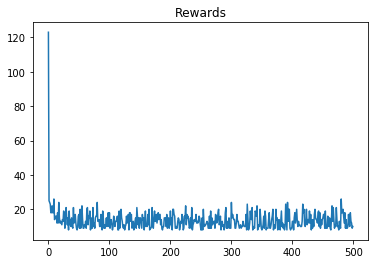

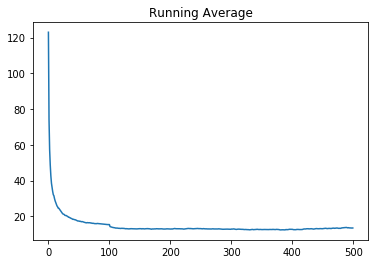

In [33]:
if __name__ == '__main__':
    main()